In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# import fashion_mnist
from tensorflow.keras.datasets import fashion_mnist

# det data (it's in touple)
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# let's see the training data and labels for first column data
print(f"Training sample:\n{X_train[0]}\n")
print(f"Training labels:\n{y_train[0]}\n")

Training sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1  

In [4]:
# data info
X_train.min(), X_train.max(), X_train.shape

(0, 255, (60000, 28, 28))

In [5]:
# preprocess the data
X_train_norm = (X_train.reshape(-1, 28, 28, 1) / 255.0)
X_test_norm = (X_test.reshape(-1, 28, 28, 1) / 255.0)

In [6]:
# normalized training data
print(f"Training sample:\n{X_train_norm[0]}\n")

Training sample:
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0

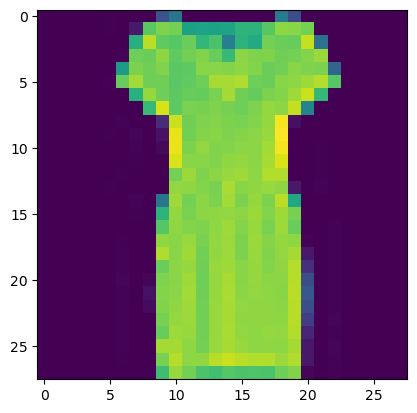

In [7]:
# diplay single image from training dataset
plt.imshow(X_train_norm[20])

In [8]:
# store label names in list
label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal","Shirt", "Sneaker", "Bag", "Ankle boot"]
len(label_names)

10

In [9]:
# plot an example image and its labels

# first let's create a reusable function
def plot_single(X, y, index):
    plt.imshow(X[index], cmap=plt.cm.binary)
    plt.title(label_names[y[index]])

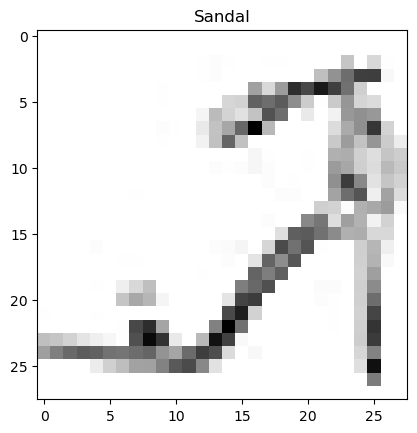

In [10]:
# now let's plot single image from data
plot_single(X_train_norm, y_train, 8)

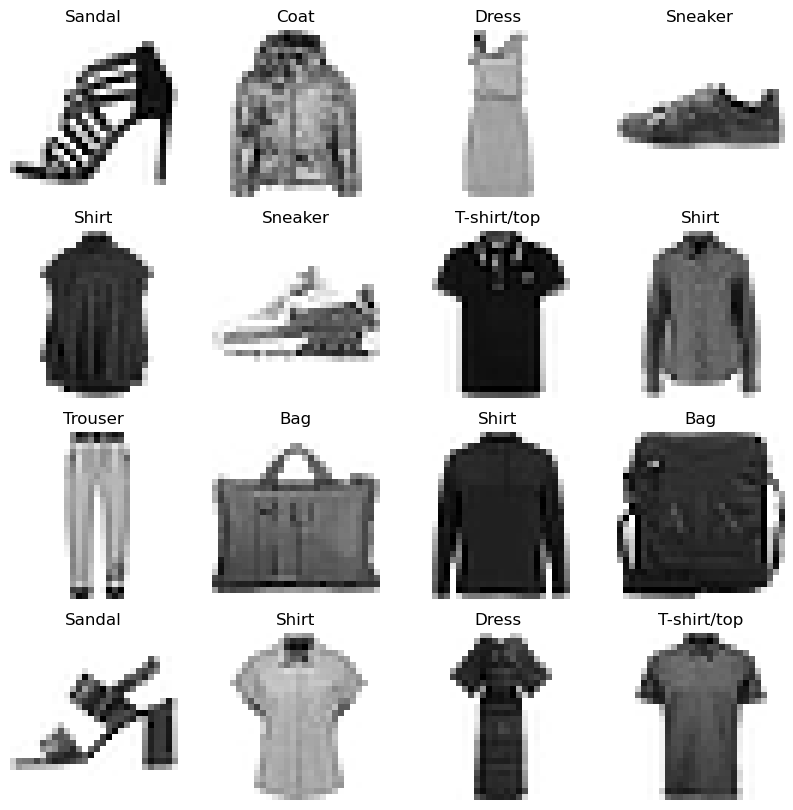

In [11]:
# plot multiple images with label
import random

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot (4, 4, i+1)
    rand_index = random.randrange(len(X_train_norm))
    plt.imshow(X_train_norm[rand_index], cmap=plt.cm.binary)
    plt.title(label_names[y_train[rand_index]])
    plt.axis(False)

In [12]:
# Define the objective function to optimize

def objective(trial):
    # define the CNN architecture
    model = models.Sequential()
    model.add(layers.Conv2D(
        trial.suggest_int("filters_1", 16, 64), (3, 3), activation='relu', input_shape=(28, 28, 1)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
        trial.suggest_int("filters_2", 32, 128), (3, 3), activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        trial.suggest_int("units", 32, 200), activation='relu'
    ))
    model.add(layers.Dense(10, activation='softmax'))
    
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])
    
    # train the model
    history = model.fit(X_train_norm, y_train, epochs=20, validation_data=(X_test_norm, y_test), verbose=0)
    
    # evaluate the model
    _, test_acc = model.evaluate(X_test_norm, y_test, verbose=0)
    
    return test_acc

In [13]:
# Define the optuna study

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Print the best trial's parameters and accuracy
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-10 07:42:52,440] A new study created in memory with name: no-name-f33c3a6d-b8ff-47bc-a4a1-6b1e55e39395
2023-07-10 07:42:52.686317: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
[I 2023-07-10 07:48:25,206] Trial 0 finished with value: 0.8962000012397766 and parameters: {'filters_1': 60, 'filters_2': 59, 'units': 65}. Best is trial 0 with value: 0.8962000012397766.
[I 2023-07-10 07:54:05,623] Trial 1 finished with value: 0.8891000151634216 and parameters: {'filters_1': 53, 'filters_2': 55, 'units': 130}. Best is trial 0 with value: 0.8962000012397766.
[I 2023-07-10 07:59:59,238] Trial 2 finished with value: 0.8946999907493591 and parameters: {'filters_1': 44, 'filters_2': 124, 'units': 168}. Best is trial 0 with value: 0.8962000012397766.
[I 2023-07-10 08:04:48,157] Trial 3 finished with value: 0.8981999754905701 and parameters: {'filters_1': 29, 'filters_2': 61, 'units': 166}. Best is trial 3 with value: 0.8981999754905701.
[I 202

Best trial:
  Value:  0.9031999707221985
  Params: 
    filters_1: 37
    filters_2: 128
    units: 95
